In [99]:
from information import *
from preprocessing import *
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from snfpy.snf import snf
import snf
from sklearn.cluster import spectral_clustering
import functions as ff
from sklearn.cluster import KMeans
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

dist = 'euclidean'
    

In [100]:
import pandas as pd
import numpy as np
D = np.load('data/MIMIC-III/temp Data/diagnosis.npy')
M = np.load('data/MIMIC-III/temp Data/medication.npy')
R = np.load('data/MIMIC-III/temp Data/procedure.npy')

print(D.shape, M.shape, R.shape)

Lung_DB = [M, R]
# Lung_DB = [D, M, R]

Lung_patients = pd.read_csv('data/MIMIC-III/temp Data/patients.csv')['Patient']

(998, 998) (998, 998) (998, 998)


# Details
- Lung has two tables
- Prostate has one table

In [101]:
df = pd.read_csv('data/MIMIC-III/temp Data/Mortality.csv')
print(df)
from datetime import datetime



# Convert ADMITTIME and DEATHTIME columns to datetime
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME'])

# Group by SUBJECT_ID and select the minimum ADMITTIME and DEATHTIME (if it exists)
new_df = df.groupby('SUBJECT_ID').agg({
    'ADMITTIME': 'min',
    'DEATHTIME': lambda x: x.min() if x.notnull().any() else pd.NaT
}).reset_index()

# Add the STATUS column based on the presence of DEATHTIME
new_df['STATUS'] = np.where(new_df['DEATHTIME'].notnull(), 1, 0)

# Rename columns
new_df.columns = ['SUBJECT_ID', 'ADMITTIME', 'DEATHTIME', 'STATUS']

new_df['ADMITTIME'] = pd.to_datetime(new_df['ADMITTIME'])

#----------------------------------------------------------------------
# Calculate the replacement value by adding five years to ADMITTIME
replacement_value = new_df['ADMITTIME'] + pd.DateOffset(years=3)

# Replace NaN values in DEATHTIME with the calculated replacement value
new_df['DEATHTIME'].fillna(replacement_value, inplace=True)

# new_df['DEATHTIME'].fillna('2206-07-27 20:52:00', inplace=True)

# Calculate the number of days between ADMITTIME and DEATHTIME
new_df['DAYS'] = (new_df['DEATHTIME'] - new_df['ADMITTIME']).dt.days


print(new_df)

      SUBJECT_ID            ADMITTIME            DEATHTIME
0             56  2104-01-02 02:01:00  2104-01-08 10:30:00
1            103  2144-08-12 17:37:00                  NaN
2            103  2144-08-30 23:09:00  2144-09-01 14:28:00
3            150  2161-07-09 17:54:00                  NaN
4            463  2198-10-05 16:43:00                  NaN
...          ...                  ...                  ...
1431       91872  2174-12-18 07:53:00  2174-12-24 03:07:00
1432       93831  2116-11-17 18:05:00                  NaN
1433       93840  2101-07-11 11:16:00                  NaN
1434       96254  2129-08-14 14:02:00  2129-08-14 20:03:00
1435       95403  2119-03-21 14:48:00                  NaN

[1436 rows x 3 columns]
     SUBJECT_ID           ADMITTIME           DEATHTIME  STATUS  DAYS
0            56 2104-01-02 02:01:00 2104-01-08 10:30:00       1     6
1           103 2144-08-12 17:37:00 2144-09-01 14:28:00       1    19
2           150 2161-07-09 17:54:00 2164-07-09 17:54:00  

In [109]:
affinity_networks = snf.make_affinity(Lung_DB, metric=dist, K=20, mu=0.5)
fused_network = snf.snf(affinity_networks, K=20)
best, _ = snf.get_n_clusters(fused_network)

Lung_labels = spectral_clustering(fused_network, n_clusters=best)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f29e1de0940>
Traceback (most recent call last):
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_p

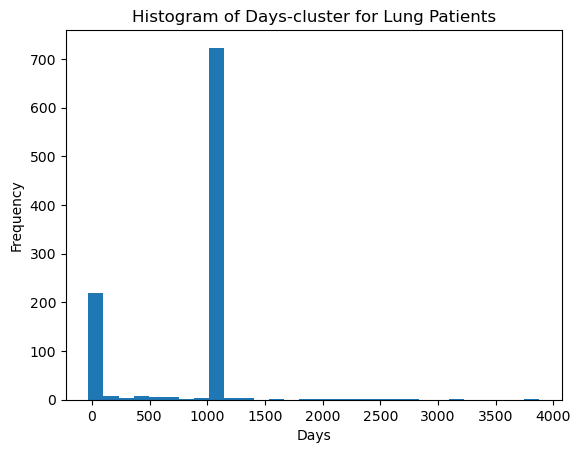

1399.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                  1276.0                  1974.0


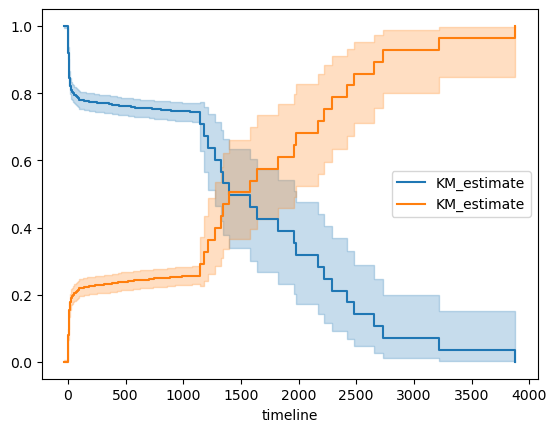

In [110]:
Lung_All     = {'SUBJECT_ID': Lung_patients    , 'cluster': list(Lung_labels) }
df_lung = pd.DataFrame(Lung_All)

Lung_survival = pd.merge(df_lung, new_df, on='SUBJECT_ID')

data = Lung_survival

T = data['DAYS']
E = data['STATUS']

plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Histogram of Days-cluster for Lung Patients')
plt.hist(T, bins = 30)
plt.show()

kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot()

kmf.plot_cumulative_density()

kmf.median_survival_time_

from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

# 3 Clusters for Lung

In [104]:
affinity_networks = snf.make_affinity(Lung_DB, metric=dist, K=20, mu=0.5)
fused_network = snf.snf(affinity_networks, K=20)
best, second = snf.get_n_clusters(fused_network)
print(best, second)
Lung_labels = spectral_clustering(fused_network, n_clusters=best)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2a9fbfbca0>
Traceback (most recent call last):
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_p

2 4


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2aa791c0d0>
Traceback (most recent call last):
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_p

Number of patients in cluser 0 = 375
Number of patients in cluser 1 = 623
1643.0
     Cluster 1_lower_0.95  Cluster 1_upper_0.95
0.5                1178.0                2421.0
P-value = (0,1) 1.7348979285615903e-11


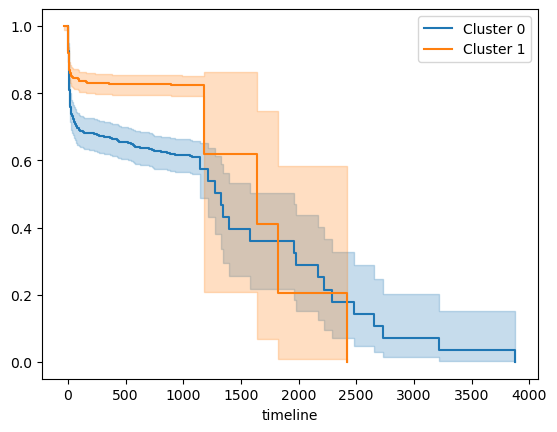

In [105]:
Lung_All     = {'SUBJECT_ID': Lung_patients    , 'cluster': list(Lung_labels)}

df_lung = pd.DataFrame(Lung_All)

Lung_survival = pd.merge(df_lung, new_df, on='SUBJECT_ID')

clusters = Lung_survival['cluster'].unique()

groups = dict(tuple(Lung_survival.groupby('cluster')))

for i in range(len(groups)):
    print(f'Number of patients in cluser {i} = {len(groups[i])}')
    
Ts = [groups[i]['DAYS'] for i in range(len(groups))]
Es = [groups[i]['STATUS'] for i in range(len(groups))]

kmf = KaplanMeierFitter()
for i in range(len(groups)):
    kmf.fit(durations = Ts[i], event_observed = Es[i], label=f'Cluster {i}')
    kmf.plot()

#kmf.plot_cumulative_density()

kmf.median_survival_time_

from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

import itertools

# Generate all combinations of length 2 from a list of integers
numbers = [i for i in range(len(groups))]
combinations = itertools.combinations(numbers, 2)

# Perform the log-rank test
for i, j in combinations:
    results = logrank_test(groups[i]['DAYS'], groups[j]['DAYS'], event_observed_A=groups[i]['STATUS'], event_observed_B=groups[j]['STATUS'])
    print(f'P-value = ({i},{j})', results.p_value)

# 4 clusters for Lung
- fusing all the PSG into one SNF (fused_network)
- find the clustering...


In [106]:
affinity_networks = snf.make_affinity(Lung_DB, metric=dist, K=20, mu=0.5)
fused_network = snf.snf(affinity_networks, K=20)
best, second = snf.get_n_clusters(fused_network)

print(best, second)

Lung_labels = spectral_clustering(fused_network, n_clusters=second)

2 4


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2a9fb095e0>
Traceback (most recent call last):
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/almusawiaf/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_p

Number of patients in cluser 0 = 315
Number of patients in cluser 1 = 472
Number of patients in cluser 2 = 145
Number of patients in cluser 3 = 66
inf
     Cluster 3_lower_0.95  Cluster 3_upper_0.95
0.5                   inf                   inf
P-value = (0,1) 0.00037340840404945295
P-value = (0,2) 8.890339897452888e-12
P-value = (0,3) 8.970771935282486e-06
P-value = (1,2) 1.0477616650383095e-06
P-value = (1,3) 0.0041702996615311716
P-value = (2,3) 0.22282005518505626


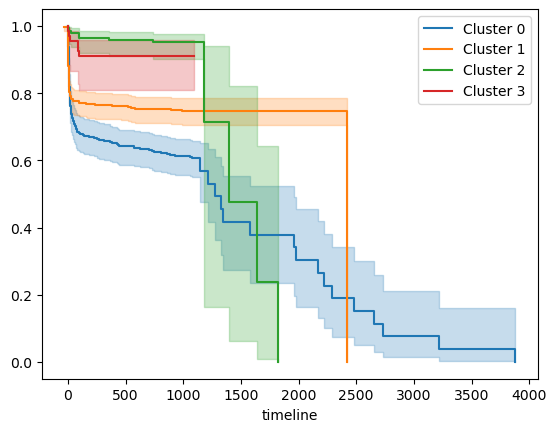

In [107]:
Lung_All     = {'SUBJECT_ID': Lung_patients    , 'cluster': list(Lung_labels)}

df_lung = pd.DataFrame(Lung_All)

Lung_survival = pd.merge(df_lung, new_df, on='SUBJECT_ID')

clusters = Lung_survival['cluster'].unique()

groups = dict(tuple(Lung_survival.groupby('cluster')))

for i in range(len(groups)):
    print(f'Number of patients in cluser {i} = {len(groups[i])}')
    
Ts = [groups[i]['DAYS'] for i in range(len(groups))]
Es = [groups[i]['STATUS'] for i in range(len(groups))]

kmf = KaplanMeierFitter()
for i in range(len(groups)):
    kmf.fit(durations = Ts[i], event_observed = Es[i], label=f'Cluster {i}')
    kmf.plot()

#kmf.plot_cumulative_density()

kmf.median_survival_time_

from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

import itertools

# Generate all combinations of length 2 from a list of integers
numbers = [i for i in range(len(groups))]
combinations = itertools.combinations(numbers, 2)

# Perform the log-rank test
for i, j in combinations:
    results = logrank_test(groups[i]['DAYS'], groups[j]['DAYS'], event_observed_A=groups[i]['STATUS'], event_observed_B=groups[j]['STATUS'])
    print(f'P-value = ({i},{j})', results.p_value)